<a href="https://colab.research.google.com/github/Crimpychimp777/actions-learning-pathway/blob/main/Norm_Elias_Final_Project_Full_code_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement
The united states government wants to understand social economic factors that influence an individuals earnings above or below 50,000 per year.


*   Target welfare and skill development programs to the right population within this dataset
*   Design policies for edcation, gender equality in the high earning jobs.
*   reduce inequality by focusing resources on groups with the highest return on investment.

Target Variable: salary( <=50k / >50K ) - boolean classification problem


Business Metric: high recall on the >50k class (minority class ~24%) so no high-income indiviual is missed for policy targeting.



In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve, recall_score, f1_score)
from sklearn.feature_selection import RFE

# Styling
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

In [48]:
#load the data and mount the drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# Load data
df= pd.read_csv('/content/drive/MyDrive/SUU Data Analytics/Final Project/who_data (1).csv')

In [50]:
df.head()

,age,workclass,fnlwgt,education,education_no_of_years,marital_status,occupation,race,sex,capital_gain,capital_loss,working_hours_per_week,native_contienent,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,White,Male,2174,0,40,north_america,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,married,Exec-managerial,White,Male,0,0,13,north_america,<=50K
2,38,Private,215646,HS-grad,9,not_married,Handlers-cleaners,White,Male,0,0,40,north_america,<=50K
3,53,Private,234721,11th,7,married,Handlers-cleaners,Black,Male,0,0,40,north_america,<=50K
4,28,Private,338409,Bachelors,13,married,Prof-specialty,Black,Female,0,0,40,north_america,<=50K


In [51]:
df.tail()

,age,workclass,fnlwgt,education,education_no_of_years,marital_status,occupation,race,sex,capital_gain,capital_loss,working_hours_per_week,native_contienent,salary
32526,27,Private,257302,Assoc-acdm,12,married,Tech-support,White,Female,0,0,38,north_america,<=50K
32527,40,Private,154374,HS-grad,9,married,Machine-op-inspct,White,Male,0,0,40,north_america,>50K
32528,58,Private,151910,HS-grad,9,not_married,Adm-clerical,White,Female,0,0,40,north_america,<=50K
32529,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,White,Male,0,0,20,north_america,<=50K
32530,52,Self-emp-inc,287927,HS-grad,9,married,Exec-managerial,White,Female,15024,0,40,north_america,>50K


In [52]:
# Let's check if there are any missing values
df.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
education_no_of_years,0
marital_status,0
occupation,0
race,0
sex,0
capital_gain,0


In [53]:
#load the data
df = pd.read_csv('/content/drive/MyDrive/SUU Data Analytics/Final Project/who_data (1).csv')
print("Shape:", df.shape)
print(df.head(3))
print("\nSalary disribution:")
print(df['salary'].value_counts())

Shape: (32531, 14)
   age         workclass  fnlwgt  education  education_no_of_years  \
0   39         State-gov   77516  Bachelors                     13   
1   50  Self-emp-not-inc   83311  Bachelors                     13   
2   38           Private  215646    HS-grad                      9   

  marital_status         occupation   race   sex  capital_gain  capital_loss  \
0  Never-married       Adm-clerical  White  Male          2174             0   
1        married    Exec-managerial  White  Male             0             0   
2    not_married  Handlers-cleaners  White  Male             0             0   

   working_hours_per_week native_contienent  salary  
0                      40     north_america   <=50K  
1                      13     north_america   <=50K  
2                      40     north_america   <=50K  

Salary disribution:
salary
<=50K    24692
>50K      7839
Name: count, dtype: int64


## Data Preprocessing & EDA

*   32,561 rows and 14 attributes + our target.
*   The Target is not balanced (~76% ≤ 50k) and greater than 50K is 24% of the  dataset.
*   **fnlwgt** is the sample weight. must be dropped.
*   **education** and **education_no_of_years** are redundant must consolidate these into reusable identifiers like a number.
*   unknown variables are scattered into the data. need to treat it as a binary category with no input. we will one-hot encode these unkowns.



In [54]:
#Clean the Data
#clean the column names and the Target
df.columns = df.columns.str.strip()
df['salary'] = df['salary'].str.strip().map({'<=50K': 0, '>50K': 1})

In [55]:
#Clean data part II
#Drop redeundant columns
df.drop(['fnlwgt', 'education'], axis=1, inplace=True )

In [56]:
#Clean data part III
#We are replacing the 'unknown' inputs with a designated category
df.replace('Uknown', 'Unkown', inplace=True)

In [57]:
#must get 0 values returned here
print("Missing values:\n", df.isnull().sum().sum())

Missing values:
 0


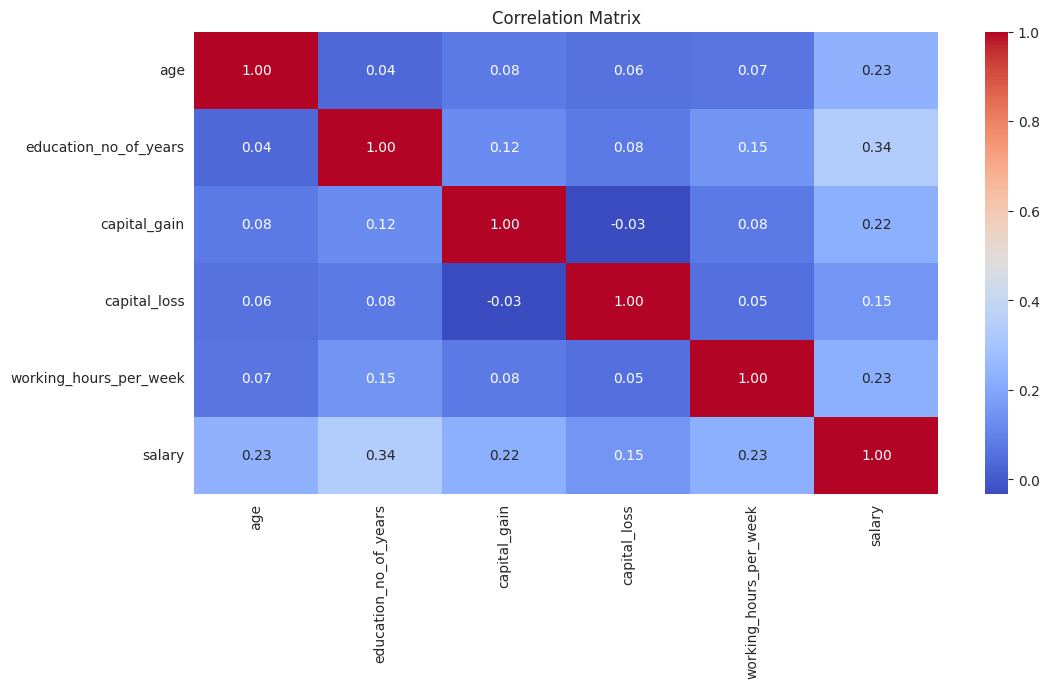

In [76]:
# Exploring Data Analysis part I
#Classic Correlation Matrix
corr = df[num_cols + ['salary']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [80]:
#Exploring Data Analysis Part II
#linear probability model on a binary target to see the direction an magnitude of the effects
#styling
print("="*50)
print("EDA OLS REGRESSION")
print("="*50)
#numerical features in linear statistical dataset
X_ols = df[['age', 'education_no_of_years', 'capital_gain',
            'capital_loss', 'working_hours_per_week']]
X_ols = sm.add_constant(X_ols) #adding the intercept
y_ols = df['salary'] # Define y_ols as the target variable
#fit OLS model
ols_model = sm.OLS(y_ols, X_ols)
olsres = ols_model.fit()

#these are the models parameters
print(olsres.params)
print("****************************")
print("****************************")

print(olsres.summary())

EDA OLS REGRESSION
const                    -0.695481
age                       0.006078
education_no_of_years     0.045830
capital_gain              0.000010
capital_loss              0.000121
working_hours_per_week    0.005413
dtype: float64
****************************
****************************
                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     1919.
Date:                Sat, 21 Feb 2026   Prob (F-statistic):               0.00
Time:                        18:03:03   Log-Likelihood:                -14322.
No. Observations:               32531   AIC:                         2.866e+04
Df Residuals:                   32525   BIC:                         2.871e+04
Df Model:                           5                             

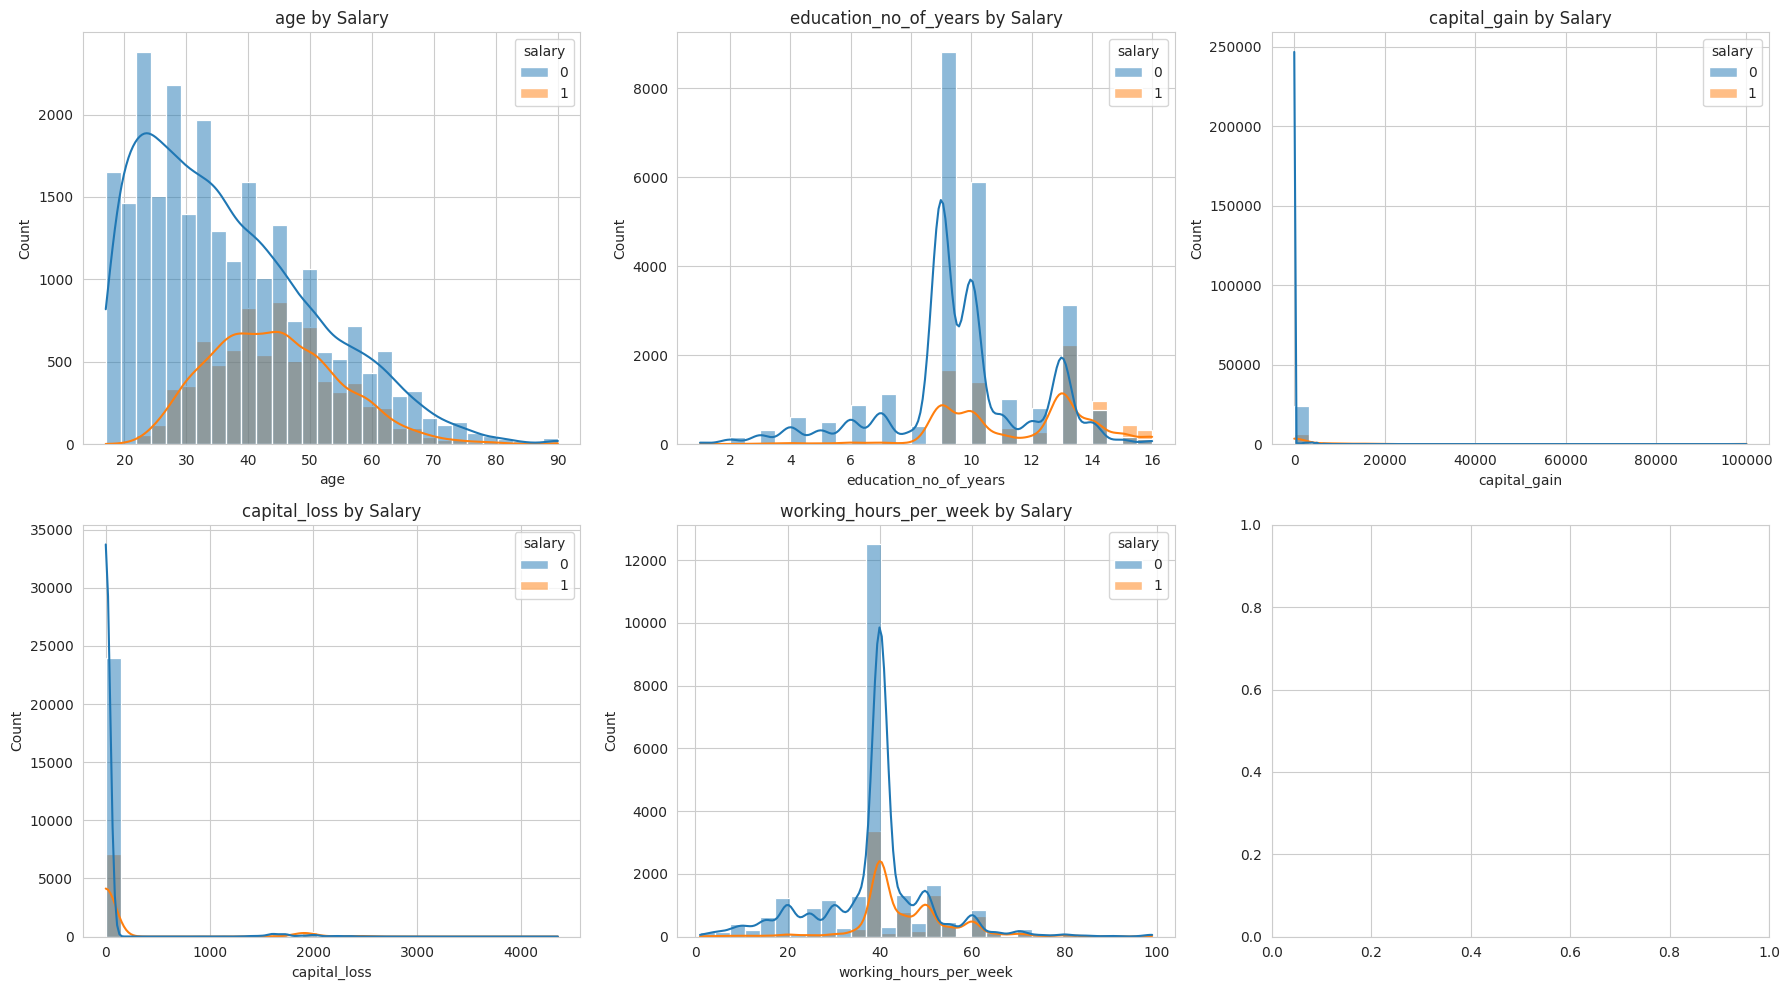

In [108]:
# Exploring Data Analysis part III
#Data visualization
num_cols = ['age', 'education_no_of_years', 'capital_gain', 'capital_loss',
            'working_hours_per_week']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, hue='salary',bins=30,kde=True,ax=axes[i//3, i%3]
                 )
    axes[i//3, i%3].set_title(f'{col} by Salary')
plt.tight_layout()
plt.show()

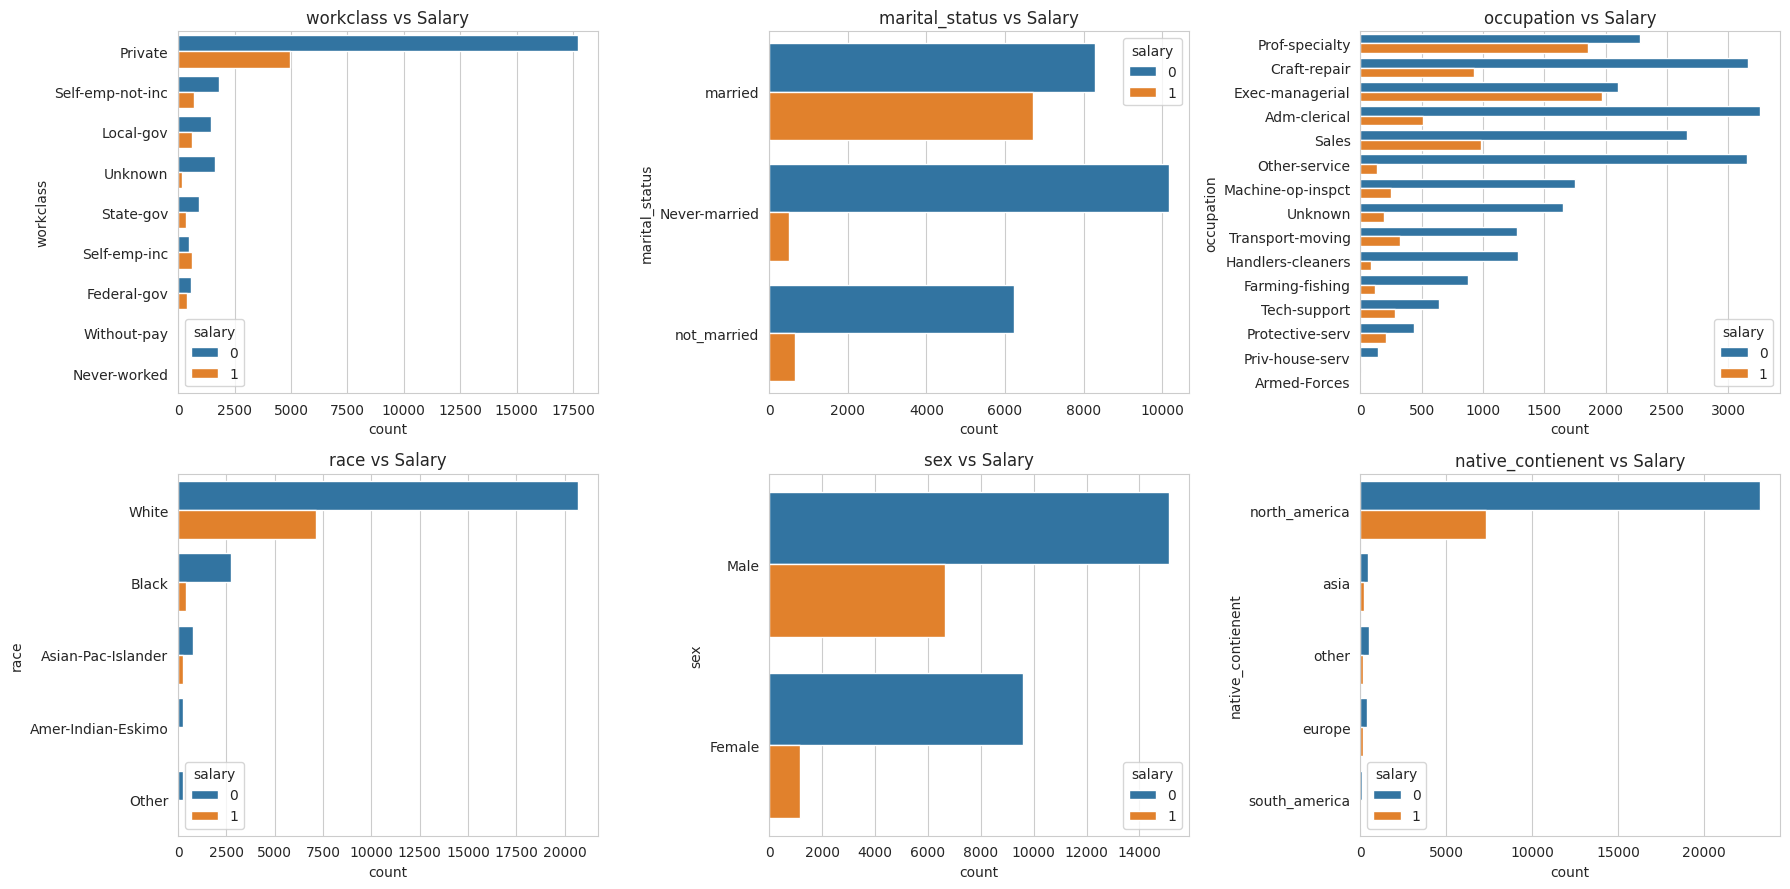

In [107]:
# Exploring Data Analysis part IV
#Data visualization
cat_cols = ['workclass', 'marital_status', 'occupation', 'race', 'sex', 'native_contienent']

fig, axes = plt.subplots(2, 3, figsize=(18, 9))
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, y=col, hue='salary', ax=axes[i//3, i%3], order=df[col].value_counts().index)
    axes[i//3, i%3].set_title(f'{col} vs Salary')
plt.tight_layout()
plt.show()

## Model Building - Logistic Regression

In [97]:
#Logisitical regression in training and testing
X = df.drop('salary', axis=1)
y = df['salary']

# ColumnTransformer will one-hot encode.

# splitting in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Reprocess the data
num_features = ['age', 'education_no_of_years', 'capital_gain',
                'capital_loss', 'working_hours_per_week']
cat_features = ['workclass', 'marital_status', 'occupation',
                'race', 'sex', 'native_contienent']

preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), num_features),
                                             ('cat', OneHotEncoder(drop='first', sparse_output=False,handle_unknown='ignore'), cat_features)])

# Apply preprocessing
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre  = preprocessor.transform(X_test)

In [98]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (26024, 11)
Shape of test set :  (6507, 11)
Percentage of classes in training set:
salary
0    0.75903
1    0.24097
Name: proportion, dtype: float64
Percentage of classes in test set:
salary
0    0.759029
1    0.240971
Name: proportion, dtype: float64


## Model Performance Evaluation

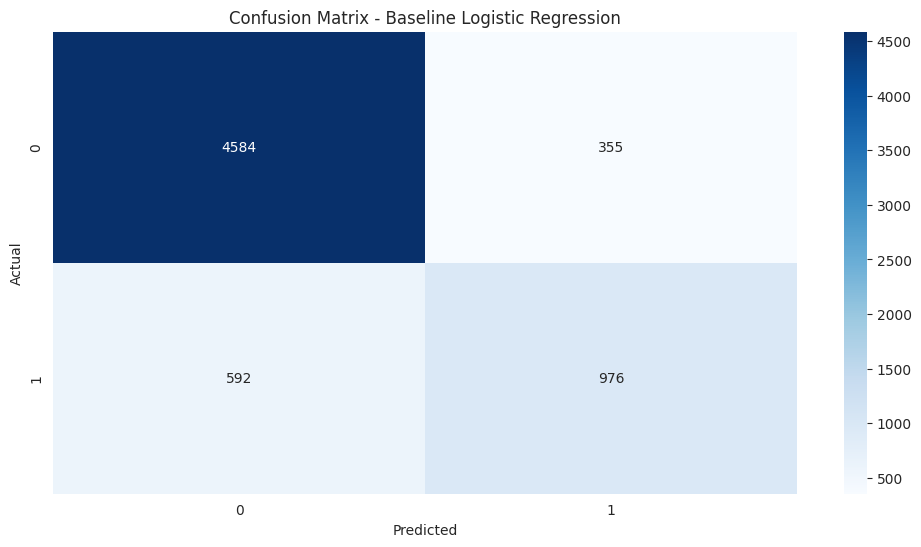

ROC-AUC: 0.9064


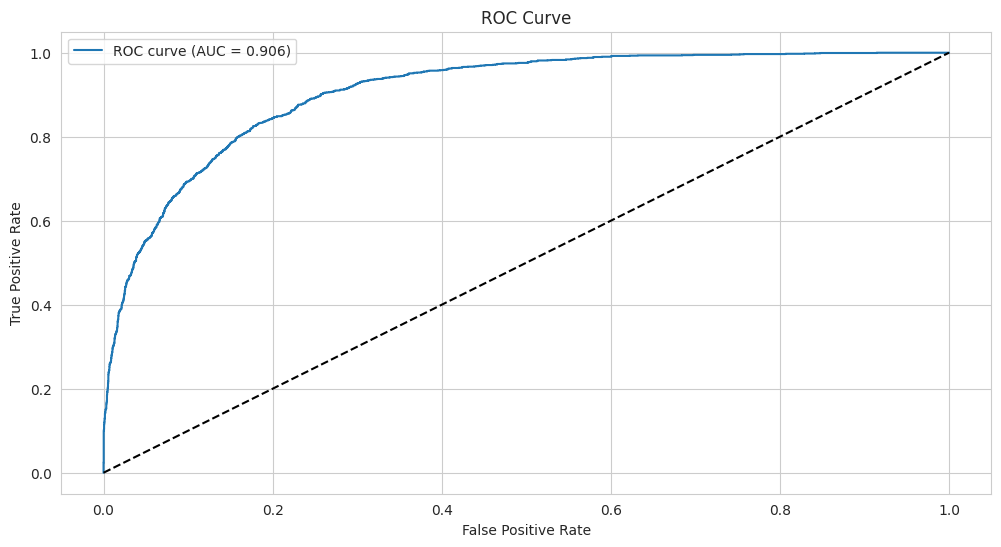

In [100]:
# Set and train a Logistic Regression model
logreg_base = LogisticRegression(random_state=42, solver='liblinear') # Using liblinear for small datasets and L1/L2 regularization
logreg_base.fit(X_train_pre, y_train)

# these are the predictions on the test set
y_pred_base = logreg_base.predict(X_test_pre)
y_pred_proba_base = logreg_base.predict_proba(X_test_pre)[:, 1] # Probability of the positive class

cm = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Baseline Logistic Regression')
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_proba_base)
print(f"ROC-AUC: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_base)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Model Performance Improvement

In [113]:
#process improvement
#search for better data parameters
param_grid = {'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
,param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)
grid_search.fit(X_train_pre, y_train)
print("Best parameters:", grid_search.best_params_)

logreg_final = grid_search.best_estimator_
y_pred_final = logreg_final.predict(X_test_pre)
y_pred_proba_final = logreg_final.predict_proba(X_test_pre)[:, 1]

Best parameters: {'C': 10, 'penalty': 'l1'}


## Model Performance Comparison and Final Model Selection

In [138]:
#Performance Conparison of Model

print("="*50)
print("\n=== BASELINE MODEL ===")
print("="*50)
print(f"Accuracy          : {acc_base:.4f} ({acc_base*100:.2f}%)")
print(f"ROC-AUC           : {auc_base:.4f}")
print(f"Recall (>50K)     : {recall_base:.4f}")
print(f"F1-Score (>50K)   : {f1_base:.4f}")

acc_base = accuracy_score(y_test, y_pred_base)
auc_base = roc_auc_score(y_test, y_pred_proba_base)
recall_base = recall_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_base))


print("="*50)
print("\n=== FINAL MODEL ===")
print("="*50)

acc_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_pred_proba_final)
recall_final = recall_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)

print(f"Accuracy          : {acc_base:.4f} ({acc_base*100:.2f}%)")
print(f"ROC-AUC           : {auc_base:.4f}")
print(f"Recall (>50K)     : {recall_base:.4f}")
print(f"F1-Score (>50K)   : {f1_base:.4f}")
print(classification_report(y_test, y_pred_final))
#


=== BASELINE MODEL ===
Accuracy          : 0.8545 (85.45%)
ROC-AUC           : 0.9064
Recall (>50K)     : 0.6224
F1-Score (>50K)   : 0.6733

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4939
           1       0.73      0.62      0.67      1568

    accuracy                           0.85      6507
   macro avg       0.81      0.78      0.79      6507
weighted avg       0.85      0.85      0.85      6507


=== FINAL MODEL ===
Accuracy          : 0.8545 (85.45%)
ROC-AUC           : 0.9064
Recall (>50K)     : 0.6224
F1-Score (>50K)   : 0.6733
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4939
           1       0.73      0.62      0.67      1568

    accuracy                           0.85      6507
   macro avg       0.81      0.78      0.79      6507
weighted avg       0.85      0.85      0.85      6507



## Conclusions and Recommendations

The capital gains is by far the strongest predictor of this dataset, it has the highest coefficient in both the OLS and the logistical regression analysis. Also with this dataset low income earners have almost always 0 capital gains meaning they dont own large scale investments. The opposite is true with high earners with capital gains. In the OLS summary statistics the capital gains data is the largest and has a p value at 0, showing its significance. Removing the cpaital gains from the model drops the ROC-AUC by appx ~.15 points.
in short: capital gains is our champion of this model and we can use it to predict with confidence the earner is making more than 50k.
Liblinear is the optimizer of this dataset, alongside the logisticregression function. These function/solvers are good for medium datasets and after our onehot encoding of 100+ columns this model becomes more stable. Using liblinear and setting it to penalty L1 gives our model better performance when tuning the model.
The ROC-AUC explained - the area under the characteristic curve tells us how well the model seperates the two classes (under 50k and over 50k) regardless of the threshold you choose. .5= random guessing, .7-.8 = acceptable and .9 is excellent. this data is imbalanced in favor of earners under 50k. furthermore accuracy can be misleading if the model just predicts everything under 50k and the ROC-AUC penalizes us for that.
Finally, knowing that capital gains is our greatest predictor, the others that show promise are the higher education years, married status and occupations in executive and professional. We also observe that gender gaps favor males to earn more. The models that we used here achieved a final score of 85.4% accuracy and our ROC-AUC of .90 makes our data reliable and predictable.
Our recommendations are the government should expand access to higher education and professional certifications, implement targeted job training programs for high-paying roles like the professional and executive designations shown in the dataset. Thirdly, we should promote finanical literacy to teach low income earners to make significant investments and increase their capital gains earnings potential. Forthly, our recommendation would be to promote subsidies for companies that promote women equally as men to close the gender wage gap. Fifthly, since married couples earn more, we would recommend to introduce family building activities whether at work or after work to ecourage stability at home to help that wage gap. With these initiatives at focus i am confident we can make positive changes an uncover earnings potential with the lower 3/4 of the data.

